In [ ]:
import os
import torch
from torch import nn
from torch import optim
import numpy as np 
import torchvision as tv
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST

In [ ]:
class Generator(nn.Module):
    def __init__(self, latent_dim=100, batchnorm=True):
        super(Generator, self).__init__()
        self.latent_dim = latent_dim
        self.batchnorm = batchnorm
        self._init_modules()

    def _init_modules(self):
        # Project the input
        self.linear1 = nn.Linear(self.latent_dim, 256*7*7, bias=False)
        self.bn1d1 = nn.BatchNorm1d(256*7*7) if self.batchnorm else None
        self.leaky_relu = nn.LeakyReLU()

        # Convolutions
        self.conv1 = nn.Conv2d(
                in_channels=256,
                out_channels=128,
                kernel_size=5,
                stride=1,
                padding=2,
                bias=False)
        self.bn2d1 = nn.BatchNorm2d(128) if self.batchnorm else None

        self.conv2 = nn.ConvTranspose2d(
                in_channels=128,
                out_channels=64,
                kernel_size=4,
                stride=2,
                padding=1,
                bias=False)
        self.bn2d2 = nn.BatchNorm2d(64) if self.batchnorm else None

        self.conv3 = nn.ConvTranspose2d(
                in_channels=64,
                out_channels=1,
                kernel_size=4,
                stride=2,
                padding=1,
                bias=False)
        self.tanh = nn.Tanh()

    def forward(self, input_tensor):
        out = self.linear1(input_tensor)
        out = self.bn1d1(out)
        out = self.leaky_relu(out)

        out = out.view((-1, 256, 7, 7))

        out = self.conv1(out)
        if self.batchnorm:
            out = self.bn2d1(out)
        out = self.leaky_relu(out)

        out = self.conv2(out)
        if self.batchnorm:
            out = self.bn2d2(out)
        out = self.leaky_relu(out)

        out = self.conv3(out)
        output_tensor = self.tanh(out)
        return output_tensor

In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self._init_modules()  

    def _init_modules(self):
        
        self.conv1 = nn.Conv2d(
                in_channels=1,
                out_channels=64,
                kernel_size=5,
                stride=2,
                padding=2,
                bias=True)
        self.leaky_relu = nn.LeakyReLU()
        self.dropout_2d = nn.Dropout2d(0.3)

        self.conv2 = nn.Conv2d(
                in_channels=64,
                out_channels=128,
                kernel_size=5,
                stride=2,
                padding=2,
                bias=True)

        self.linear1 = nn.Linear(128*7*7, 1, bias=True)
        self.sigmoid = nn.Sigmoid()

    def forward(self, input_tensor):
        
        out = self.conv1(input_tensor)
        out = self.leaky_relu(out)
        out = self.dropout_2d(out)

        out = self.conv2(out)
        out = self.leaky_relu(out)
        out = self.dropout_2d(out)

        out = out.view((-1, 128*7*7))
        out = self.linear1(out)
        output_tensor = self.sigmoid(out)

        return output_tensor

In [ ]:
class DCGAN():
    def __init__(self, latent_dim, noise_fn, dataloader,
                 batch_size=32, device='cpu', lr_d=1e-3, lr_g=2e-4):
        self.generator = Generator(latent_dim).to(device)
        self.discriminator = Discriminator().to(device)
        self.noise_fn = noise_fn
        self.dataloader = dataloader
        self.batch_size = batch_size
        self.device = device
        self.criterion = nn.BCELoss()
        self.optim_d = optim.Adam(self.discriminator.parameters(),
                                  lr=lr_d, betas=(0.5, 0.999))
        self.optim_g = optim.Adam(self.generator.parameters(),
                                  lr=lr_g, betas=(0.5, 0.999))
        self.target_ones = torch.ones((batch_size, 1), device=device)
        self.target_zeros = torch.zeros((batch_size, 1), device=device)

    def generate_samples(self, latent_vec=None, num=None):
        num = self.batch_size if num is None else num
        latent_vec = self.noise_fn(num) if latent_vec is None else latent_vec
        with torch.no_grad():
            samples = self.generator(latent_vec)
        samples = samples.cpu()  # move images to cpu
        return samples

    def train_step_generator(self):
        self.generator.zero_grad()

        latent_vec = self.noise_fn(self.batch_size)
        generated = self.generator(latent_vec)
        classifications = self.discriminator(generated)
        loss = self.criterion(classifications, self.target_ones)
        loss.backward()
        self.optim_g.step()
        return loss.item()

    def train_step_discriminator(self, real_samples):
        self.discriminator.zero_grad()

        # real samples
        pred_real = self.discriminator(real_samples)
        loss_real = self.criterion(pred_real, self.target_ones)

        # generated samples
        latent_vec = self.noise_fn(self.batch_size)
        with torch.no_grad():
            fake_samples = self.generator(latent_vec)
        pred_fake = self.discriminator(fake_samples)
        loss_fake = self.criterion(pred_fake, self.target_zeros)

        # combine
        loss = (loss_real + loss_fake) / 2
        loss.backward()
        self.optim_d.step()
        return loss_real.item(), loss_fake.item()

    def train_epoch(self, print_frequency=10, max_steps=0):
        loss_g_running, loss_d_real_running, loss_d_fake_running = 0, 0, 0
        for batch, (real_samples, _) in enumerate(self.dataloader):
            real_samples = real_samples.to(self.device)
            ldr_, ldf_ = self.train_step_discriminator(real_samples)
            loss_d_real_running += ldr_
            loss_d_fake_running += ldf_
            loss_g_running += self.train_step_generator()
            if print_frequency and (batch+1) % print_frequency == 0:
                print(f"{batch+1}/{len(self.dataloader)}:"
                      f" G={loss_g_running / (batch+1):.3f},"
                      f" Dr={loss_d_real_running / (batch+1):.3f},"
                      f" Df={loss_d_fake_running / (batch+1):.3f}",
                      end='\r',
                      flush=True)
            if max_steps and batch == max_steps:
                break
        if print_frequency:
            print()
        loss_g_running /= batch
        loss_d_real_running /= batch
        loss_d_fake_running /= batch
        return (loss_g_running, (loss_d_real_running, loss_d_fake_running))

Epoch 1; Elapsed time = 0s

Epoch 2; Elapsed time = 57s

Epoch 3; Elapsed time = 114s

Epoch 4; Elapsed time = 170s

Epoch 5; Elapsed time = 227s

Epoch 6; Elapsed time = 284s

Epoch 7; Elapsed time = 341s

Epoch 8; Elapsed time = 398s

Epoch 9; Elapsed time = 455s

Epoch 10; Elapsed time = 512s



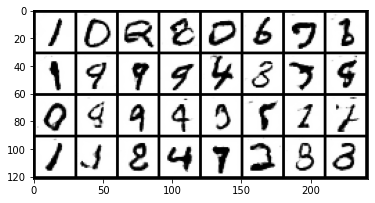

In [ ]:
def main():
    import matplotlib.pyplot as plt
    from time import time
    batch_size = 32
    epochs = 10
    latent_dim = 16
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    transform = tv.transforms.Compose([
            tv.transforms.Grayscale(num_output_channels=1),
            tv.transforms.ToTensor(),
            tv.transforms.Normalize((0.5,), (0.5,))
            ])
    dataset = MNIST(root='/data', download = True, transform=transform)
    dataloader = DataLoader(dataset,
            batch_size=batch_size,
            shuffle=True,
            num_workers=2
            )
    noise_fn = lambda x: torch.randn((x, latent_dim), device=device)
    gan = DCGAN(latent_dim, noise_fn, dataloader, device=device, batch_size=batch_size)
    start = time()
    for i in range(10):
        print(f"Epoch {i+1}; Elapsed time = {int(time() - start)}s")
        gan.train_epoch()
    images = gan.generate_samples() * -1  # invert colours, for aesthetics
    ims = tv.utils.make_grid(images, normalize=True)
    plt.imshow(ims.numpy().transpose((1,2,0)))
    plt.show()


if __name__ == "__main__":
    main()